<a href="https://colab.research.google.com/github/martaarozarena/KSchool-Master-Final-Project/blob/master/exog_varaibles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and create initial variables

In [179]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 8)

In [180]:
# We select the countries and dates our project will focus on:

countries = 'Denmark|Germany|Spain|Finland|Italy|Sweden|France|Norway|United Kingdom' \
            '|United States|Canada|Mexico' \
            '|Australia|Indonesia|Malaysia|Philippines|Thailand|Vietnam|China|India|Japan|Singapore|Taiwan' \
            '|Saudi Arabia|United Arab Emirates'

countriesEU = 'Denmark|Germany|Spain|Finland|Italy|Sweden|France|Norway|United Kingdom'

# First day of the year, which will be used to set the begin date of the series:
initialdate = '2020-01-01'   

# Yesterday's date: which will be assumed to be the last day of available data
#(if no available data for 'yesterday', we will use last available data and extend it):
enddate = str(date.fromordinal(date.today().toordinal()-1))

# Full time series index to be used for all our data:
full_index = pd.date_range(initialdate, enddate, freq='D')

# Reading coronavirus data from Our World in Data

In [181]:
# We read the data from Our World in Data website. 'New_cases' and 'new_deaths' will be the endogenous data. 
# 'Positive_rate' will be one of our exogenous variables

url0 = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid = pd.read_csv(url0, parse_dates=['date'], index_col='date', usecols=['date','location', 'new_cases', 'new_deaths', 'positive_rate'])

In [182]:
# We filter the countries we'll be using for our project, filter the dates and put all data in columns with a single datetime index for all

coviddata = pd.DataFrame(index=full_index)

for i in countries.split('|'):
    covid_ctry = covid[covid["location"]==i].truncate(initialdate, enddate)
    covid_ctry_new_cases = covid_ctry['new_cases']
    covid_ctry_new_cases.rename('new_cases_{}'.format(i), inplace=True)
    covid_ctry_new_deaths = covid_ctry['new_deaths']
    covid_ctry_new_deaths.rename('new_deaths_{}'.format(i), inplace=True)
    covid_ctry_positive_rate = covid_ctry['positive_rate']
    covid_ctry_positive_rate.rename('positive_rate_{}'.format(i), inplace=True)
    coviddata = pd.concat([coviddata, covid_ctry_new_cases, covid_ctry_new_deaths, covid_ctry_positive_rate], axis=1)

In [183]:
# Preparing the endogenous data  ('new_cases' and 'new_deaths'): first apply 7-day rolling mean and then interporlate missing values:
endogenous = coviddata.drop(coviddata.iloc[:, coviddata.columns.str.contains('positive_rate')], axis=1)
endogenous = endogenous.rolling(7).mean().interpolate(method='linear', limit_direction='both')

In [184]:
endogenous.shape, endogenous.isna().sum().sum()

((264, 50), 0)

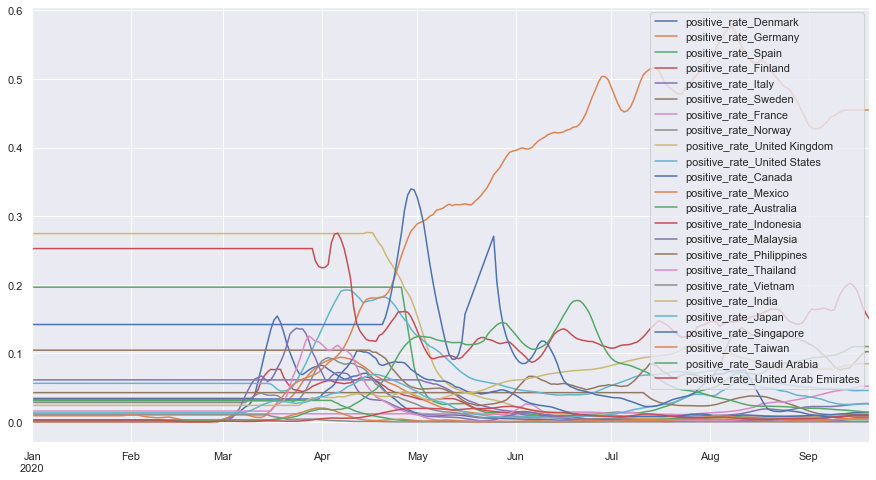

In [185]:
# Preparing the first variable of the exogenous data  ('positive_rate')
exogenous = coviddata.iloc[:, coviddata.columns.str.contains('positive_rate')]
exogenous = exogenous.drop('positive_rate_China', axis=1) 
exogenous = exogenous.rolling(7).mean().interpolate(method='linear', limit_direction='both')
exogenous.plot()

In [186]:
exogenous.shape, exogenous.isna().sum().sum()

((264, 24), 0)

# Downloading and preparing the Oxford Covid Policy Tracker data

In [187]:
#othercols = ['date', 'countryname', 'regionname', 'regioncode']
#variables = ['c1_schoolclosing', 'c2_workplaceclosing', 'c3_cancelpublicevents', \
#           'c4_restrictionsongatherings', 'c5_closepublictransport', 'c6_stayathomerequirements', \
#           'c7_restrictionsoninternalmovemen', 'c8_internationaltravelcontrols', \
#           'h1_publicinformationcampaigns', 'h2_testingpolicy', 'h3_contacttracing']
#columns = othercols + variables

In [188]:
othercols = ['Date', 'CountryName', 'RegionName', 'RegionCode']
variables = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', \
           'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements', \
           'C7_Restrictions on internal movement', 'C8_International travel controls', \
           'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing']
columns = othercols + variables

In [189]:
#url1 = 'https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv'
#ox_policy = pd.read_csv(url1, parse_dates=['date'], index_col='date', usecols=columns, dtype={'regionname':str, 'regioncode':str})
#ox_policy = ox_policy[ox_policy['regioncode'].isna()]

In [191]:
url1 = 'https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv'
ox_policy = pd.read_csv(url1, parse_dates=['Date'], index_col='Date', usecols=columns, dtype={'RegionName':str, 'RegionCode':str})
ox_policy = ox_policy[ox_policy['RegionCode'].isna()]

In [192]:
#for i in countries.split('|'):
#    print(i, len(ox_policy[ox_policy['countryname']==i].index))

In [193]:
#ox_ex = pd.DataFrame(index=full_index)

#for i in countries.split('|'):
#    ox_ctry = ox_policy[ox_policy['countryname']==i].truncate(initialdate, enddate)
#    for col in variables:
#        ox_ctry_col = ox_ctry[col]
#        ox_ctry_col.rename(col+'_{}'.format(i), inplace=True)
#        ox_ex = pd.concat([ox_ex, ox_ctry_col], axis=1)

In [194]:
ox_ex = pd.DataFrame(index=full_index)

for i in countries.split('|'):
    ox_ctry = ox_policy[ox_policy['CountryName']==i].truncate(initialdate, enddate)
    for col in variables:
        ox_ctry_col = ox_ctry[col]
        ox_ctry_col.rename(col+'_{}'.format(i), inplace=True)
        ox_ex = pd.concat([ox_ex, ox_ctry_col], axis=1)

In [195]:
ox_ex = ox_ex.rolling(7).mean().interpolate(method='linear', limit_direction='both')
exogenous = pd.concat([exogenous, ox_ex], axis=1)

In [196]:
exogenous.shape, exogenous.isna().sum().sum()

((264, 299), 0)

# Downloading and preparing the mask wearing data (YouGov)

In [197]:
# We download the mask wearing data
url2 = 'https://drive.google.com/file/d/1vvj9dfvL7c16q3ZrrrFJiJ3T-uH0Yx6n/view?usp=sharing'
path2 = 'https://drive.google.com/uc?export=download&id='+url2.split('/')[-2]
var_percent_mask = pd.read_csv(path2, sep=";", parse_dates=['DateTime'], index_col=['DateTime'])

In [198]:
# We extend the dates to match those of the general exogenous dataframe, apply 7-rolling mean and
# we interpolate to fill all the missing values (initializing the series at 0):
var_percent_mask.index = pd.to_datetime(var_percent_mask.index).date
var_percent_mask = var_percent_mask.reindex(exogenous.index)
var_percent_mask.iloc[0] = 0
var_percent_mask = var_percent_mask.interpolate(method='linear', limit_direction='both')
var_percent_mask = var_percent_mask.rolling(7).mean()
var_percent_mask.iloc[0] = 0
var_percent_mask = var_percent_mask.interpolate(method='linear', limit_direction='both')

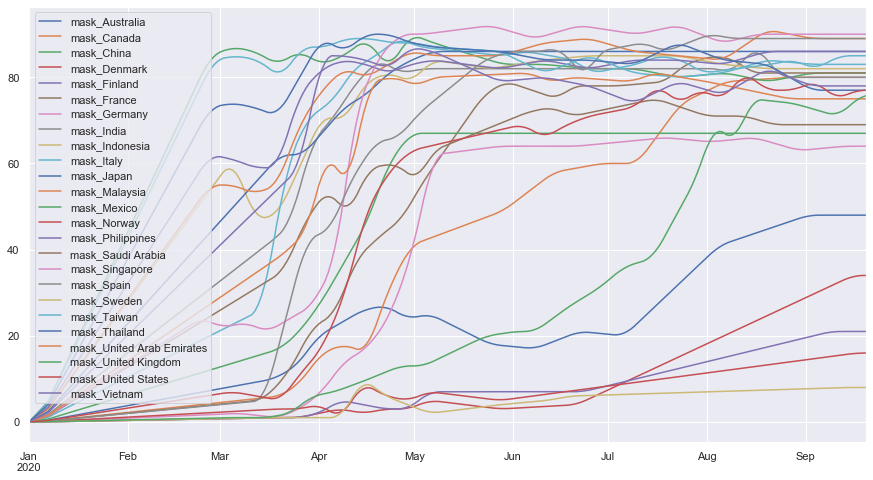

In [199]:
#rename the variable's columns to be added in the general exogenous dataframe
var_percent_mask.columns = 'mask_' + var_percent_mask.columns
var_percent_mask.rename(columns={'mask_UAE' : 'mask_United Arab Emirates', 'mask_UK' : 'mask_United Kingdom', 
                                 'mask_USA' : 'mask_United States'}, inplace=True)
var_percent_mask.drop('mask_Hong Kong', axis=1, inplace=True)
var_percent_mask.plot()

In [200]:
#add the mask data to the rest of exogenous dataframe
exogenous = pd.concat([exogenous, var_percent_mask], axis=1)

In [201]:
exogenous.shape, exogenous.isna().sum().sum()

((264, 324), 0)

# Downloading and preparing the Flights data (we only have it available for Europe)

In [202]:
#Downloading daily flights from Eurocontrol or, alternatively, reading it from the drive, since this data only changes once a month
url3 = "https://drive.google.com/file/d/1jLzSGGbQY8OyD1YTNZAJFRmvxy7lA2V_/view?usp=sharing"
path3 = 'https://drive.google.com/uc?export=download&id='+url3.split('/')[-2]
#url3 = 'https://ansperformance.eu/download/xls/Airport_Traffic.xlsx'
flights = pd.read_excel(path3, sheet_name="DATA", date_parser="FLT_DATE", index_col ="FLT_DATE")

In [203]:
# Extracting the number of arrival flights for the European selected countries (Eurocontrol data is only for European countries):
for i in countriesEU.split('|'):
    flights_country = flights[flights["STATE_NAME"]==i]
    flights_country = flights_country.resample("1D").sum()
    flights_country_arr = flights_country['FLT_ARR_1'].truncate(initialdate, enddate)
    flights_country_arr.rename("flightsArr_{}".format(i),inplace=True)
    exogenous = pd.concat([exogenous, flights_country_arr], axis=1)

In [204]:
# We apply 7-day rolling mean and interpolate the missing values at the end of the data (daily flights are only published once a month):

exogenous.loc[:, exogenous.columns.str.contains('flights')] = exogenous.loc[:, exogenous.columns.str.contains('flights')].rolling(7).mean()
exogenous.loc[:, exogenous.columns.str.contains('flights')] = exogenous.loc[:, exogenous.columns.str.contains('flights')].interpolate(method='linear', limit_direction='both')

In [205]:
# We keep the data for the selected European countries, since this data comes from Eurocontrol (only for European countries):
#exogenous = exogenous.iloc[:, exogenous.columns.str.contains(countriesEU)]

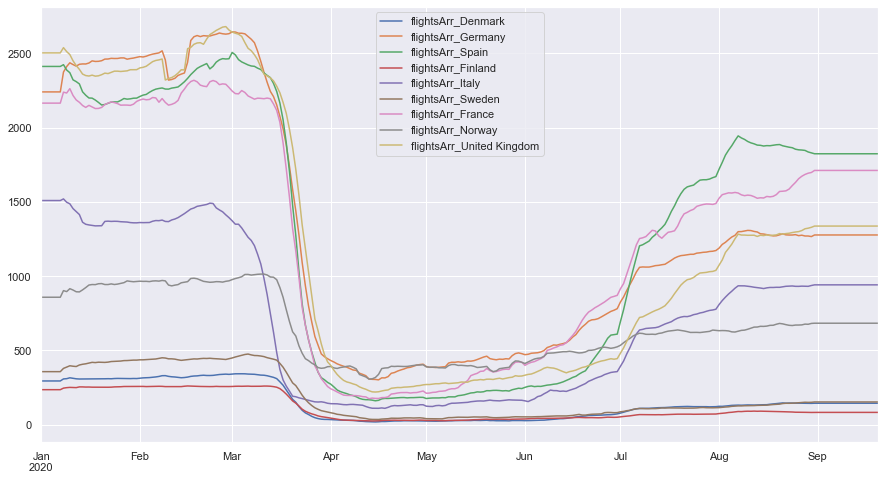

In [206]:
exogenous.loc[:, exogenous.columns.str.contains('flights')].plot()

In [207]:
exogenous.shape, exogenous.isnull().sum().sum()

((264, 333), 0)

# Creating the csv files with all the endogenous and exogenous data

In [208]:
#creating the csv file
endogenous.to_csv('./data/endogenous.csv', index_label='date')
exogenous.to_csv('./data/exogenous.csv', index_label='date')